# Session 3: Populations of LIF Neurons

In [ ]:
import numpy as np
import pylab as plt
import nest

<frozen importlib._bootstrap>:228: RuntimeWarning: compiletime version 3.8 of module 'pynestkernel' does not match runtime version 3.9



              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.3
 Built: May  5 2022 07:35:57

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



## About this tutorial
In this tutorial you are going to use the NEST SIMULATOR. This tool is used to efficiently model large networks of point-neurons. The tool is not optimized to simulate multi-compartmental models like NEURON but is designed to model simpler point-neuron models. As shown in the lecture point-neuron models can be fitted to a large range of biological neurons. Their advantage compared to more complicated neuron models is their mathematical tractability but also their computational efficiency. Their efficiency makes it possible to simulate very large networks of point-neuron models.

In this tutorial we will create the well known Brunel network. This network consists of two populations of LIF neurons. One of the populations is excitatory and the other one is inhibitory. There are 4 times as many excitatory neurons than inhibitory neurons in the network (similar to proportions found in the cortex), but the synaptic efficacy of inhibitory neurons on excitatory neurons will offset this difference and thus balances out the network. This balanced state is one of several dynamical regimes the network can occupy. You will explore the other regimes as well.

Finally, you will visualize the evolution of the membrane potential of the populations over time. The evolution of the distribution of the membrane potential is central to mean-field theories and the visualization will be help you in understanding the next lectures.

## Create the network
In nest the main functions you need for creating a network are *nest.Create()* and *nest.Connect()*. With the *nest.Create()* function you can create populations of neurons, external input devices (e.g. current generators) and recording devices (e.g. spike recorders). The *nest.Connect()* function is required to connect all the components.

Let's create 2 populations of neurons. The neuron model we use is *iaf_psc_delta*, meaning a LIF neuron with a delta-shaped post-synaptic current function (see NEST documentation for more details). The parameters of the neuron model are provided in the dictionary below. The total number of neurons is *10000* of which 80% are excitatory neurons and 20% are inhibitory neurons. Use python indexing to create an excitatory and an inhibitory population.

In [ ]:
neuron_params = {
                   'C_m':       1.0,
                   'tau_m':     20.0,
                   't_ref':     2.0,
                   'E_L':       0.0,
                   'V_th':      20.0,
                   'V_reset':   10.0
                   }

N = 10000
N_E = int(0.8*N)
N_I = int(0.2*N)
neurons = nest.Create('iaf_psc_delta', N, params=neuron_params)
neurons_E = neurons[:N_E]
neurons_I = neurons[N_E:]

Now we connect the populations. The synaptic efficacy of the inhibitory synapses should offset the excitatory synapses to balance the network. Below the parameters of the network are provided. Connect the neurons using the *nest.Connect()* function. This function takes the source, the target and 2 optional arguments: *syn_spec*, defines the properties of the synapse; and *conn_spec* which provides the connection algorithm (i.e. how are connections from source population to target population divided over the population). For this network these parameters are provided.

In [ ]:
g   = -5                # excitation-inhibition balance
J_E = 0.1               # excitatory synaptic efficacy
J_I = g * J_E           # inhibitory synaptic efficacy
P = 0.1                 # connection probability
K_E = int(N_E * 0.1)    # number of excitatory synapses
K_I = int(N_I * 0.1)    # number of inhibitory synapses
delay = 1.5             # axonal delay

syn_spec_E  = {'weight': J_E,
               'delay': delay}
syn_spec_I  = {'weight': J_I,
               'delay': delay}

conn_spec_E = {'rule': 'fixed_indegree',
               'indegree': K_E}
conn_spec_I = {'rule': 'fixed_indegree',
               'indegree': K_I}


nest.Connect(neurons_E, neurons, conn_spec=conn_spec_E, syn_spec=syn_spec_E)
nest.Connect(neurons_I, neurons, conn_spec=conn_spec_I, syn_spec=syn_spec_I)

Next we create external input devices to drive the network so that we have some spiking activity. We do this by creating a Poission generator, give it a certain rate and connect it to all neurons in our network. The rate of the Poission generated is calculated by interpreting it as a external population which has a certain rate. A function is provided which takes as input a single parameter (relative external rate: *eta*) which can be used to obtain the rate for the Poisson generator. The relative external rate (*eta*) will be one of the main parameters to tune to move between different dynamical regimes of the network.

Let's create and connect the *poisson_generator*!

In [ ]:
eta = 1.0
def get_poisson_rate(eta, tau_m=20.0, V_th=20.0, J_E=0.1):
    return 1000.0 * eta * V_th / (J_E*tau_m)

p_rate = get_poisson_rate(eta)

poisson = nest.Create('poisson_generator', 1, {'rate': p_rate})

nest.Connect(poisson, neurons, syn_spec=syn_spec_E) # use excitatory synapses; no conn_spec required (see NEST documentation for default options)

The final thing we need to do is create recording devices. We will for now create a spiking recorder which (as the name says) records the spikes from the populations it is connected to. After simulation the times and senders of the recorded spikes can be obtained. Record from only 5% of the neurons in the populations.

In [ ]:
spikes_E = nest.Create('spike_recorder')
spikes_I = nest.Create('spike_recorder')

nrec_E = int(N_E * 0.05)
nrec_I = int(N_I * 0.05)

nest.Connect(neurons_E[:nrec_E], spikes_E)
nest.Connect(neurons_I[:nrec_I], spikes_I)

Now we are ready to simulate the network!

In [ ]:
nest.SetKernelStatus({'print_time': True})

t_sim = 300 # ms
nest.Simulate(t_sim)


Sep 08 14:19:46 NodeManager::prepare_nodes [Info]: 
    Preparing 10003 nodes for simulation.

Sep 08 14:19:47 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 10003
    Simulation time (ms): 300
    Number of OpenMP threads: 1
    Number of MPI processes: 1

[  53% ] Model time: 158.0 ms, Real-time factor: 9.6146

### Task 1: Raster plot (50 points)
Using *nest.GetStatus()* we can access the data recorded by the spike recorders. Use this function to investigate the recorded data and try to make a raster plot of the excitatory and inhibitory spike trains. The network we build is based on the network described in [Brunel (2000)](https://link.springer.com/content/pdf/10.1023/A:1008925309027.pdf). Figure 8 in this paper shows raster plots of different regimes. To which of the possible regimes would you assign the current simulation? By tuning *g* and *eta* could you visit the other dynamical regimes as well?

In [ ]:
senders_E = nest.GetStatus(spikes_E, 'events')[0]['senders']
times_E   = nest.GetStatus(spikes_E, 'events')[0]['times']

senders_I = nest.GetStatus(spikes_I, 'events')[0]['senders']
times_I   = nest.GetStatus(spikes_I, 'events')[0]['times']

[ 100% ] Model time: 300.0 ms, Real-time factor: 10.3913

Sep 08 14:19:51 SimulationManager::run [Info]: 
    Simulation finished.


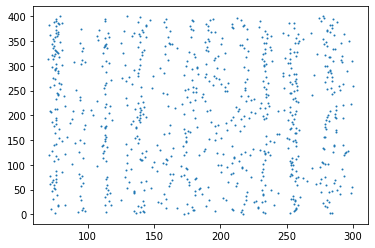

In [ ]:
plt.scatter(times_E, senders_E, s=1)

### Task 2: Visualize the evolution of the membrane potential (50 points)
Create *voltmeter* devices and connect them to the 2 populations. Visualize the evolution of the membrane potential of the neurons in the network over time. Give the voltmeter (in *nest.Create()* *params* argument) a recording *interval* of 1 ms and record from the membrane voltage of the neurons *V_m*. Record from 5% of the neurons to limit computational cost. note that with for connecting a *voltmeter* with *nest.Connect()* you need to put the *voltmeter* as the source. What happens at the reset potential *V_reset*? What happens around the spike threshold potential *V_th*? Try to explain your observations.

In [ ]:
voltage_E = nest.Create('voltmeter', params={'interval': 1., 'record_from': ['V_m']})
voltage_I = nest.Create('voltmeter', params={'interval': 1., 'record_from': ['V_m']})

nrec_E = int(N_E * 0.10)
nrec_I = int(N_I * 0.10)

nest.Connect(voltage_E, neurons_E[:nrec_E])
nest.Connect(voltage_I, neurons_I[:nrec_I])

In [ ]:
nest.SetKernelStatus({'print_time': True})

t_sim = 300 # ms
nest.Simulate(t_sim)


Sep 08 14:50:23 NodeManager::prepare_nodes [Info]: 
    Preparing 10009 nodes for simulation.

Sep 08 14:50:24 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 10009
    Simulation time (ms): 300
    Number of OpenMP threads: 1
    Number of MPI processes: 1

[  68% ] Model time: 1104.0 ms, Real-time factor: 11.7388

In [ ]:
times = nest.GetStatus(voltage_E, 'events')[0]['times']
V_m_E = nest.GetStatus(voltage_E, 'events')[0]['V_m']
V_m_I = nest.GetStatus(voltage_I, 'events')[0]['V_m']

[ 100% ] Model time: 1200.0 ms, Real-time factor: 11.5814

Sep 08 14:50:27 SimulationManager::run [Info]: 
    Simulation finished.


In [ ]:
min_times = np.min(times)
max_times = np.max(times)

data = []
bins = []
for i in range(len(np.unique(times))):
    idx = np.where(times == min_times+i)[0]
    data_, bins_ = np.histogram(V_m_E[idx], bins=200)
    data.append(data_)
    bins.append(bins_)
data = np.array(data)
bins = np.array(bins)

# normalize data
data = (data - np.min(data)) / (np.max(data) - np.min(data))

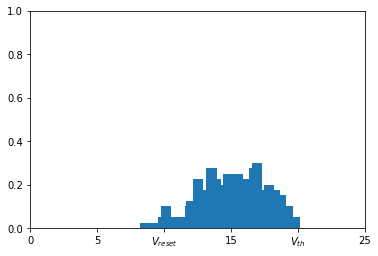

In [ ]:
import matplotlib.animation as animation
import matplotlib
matplotlib.use("TkAgg")

number_of_frames = np.shape(data)[0]

def update_hist(num, data):
    plt.cla()
    plt.bar(x=bins[num,:-1], height=data[num])
    plt.xlim(left=0, right=neuron_params['V_th']+5)
    plt.xticks([0, 5, neuron_params['V_reset'], 15, neuron_params['V_th'], 25], 
               [0, 5, r'$V_{reset}$', 15, r'$V_{th}$', 25])
    plt.ylim(bottom=0, top=1)

fig = plt.figure()
plt.xlim(left=0, right=neuron_params['V_th']+5)
plt.xticks([0, 5, neuron_params['V_reset'], 15, neuron_params['V_th'], 25], 
           [0, 5, r'$V_{reset}$', 15, r'$V_{th}$', 25])
plt.ylim(bottom=0, top=1)
plt.bar(x=bins[0,:-1], height=data[0])

animation = animation.FuncAnimation(fig, update_hist, number_of_frames, fargs=(data, ), interval=20)

from IPython.display import HTML
HTML(animation.to_jshtml())